In [1]:
# !pip install healpy
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
%matplotlib inline

In [2]:
# Planck fiducial power spectrum
l, TT, TE, EE, BB, PP = np.loadtxt('COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt',unpack=True)
l = l.astype(int)

In [3]:
nside = 512
lmin = 2
lmax = 2 * nside

# Create an array of zeros
Cl_tt = np.zeros(lmax + 1)
Cl_ee = np.zeros(lmax + 1)
Cl_bb = np.zeros(lmax + 1)
Cl_te = np.zeros(lmax + 1)

# Set limits on l and apply the filter
mask = (l >= lmin) & (l <= lmax)
l_masked = l[mask]


# Convert D_ell -> C_ell for the masked multipoles
factor = 2.0 * np.pi / (l_masked * (l_masked + 1))
Cl_tt[l_masked] = TT[mask] * factor
Cl_ee[l_masked] = EE[mask] * factor
Cl_bb[l_masked] = BB[mask] * factor
Cl_te[l_masked] = TE[mask] * factor  # TE sign is preserved

# Healpy synfast expects [TT, EE, BB, TE]
cls = [Cl_tt, Cl_ee, Cl_bb, Cl_te]


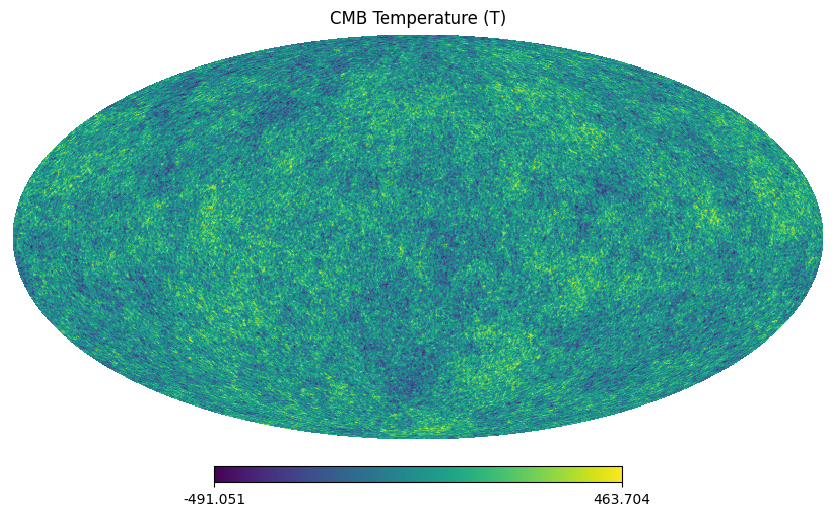

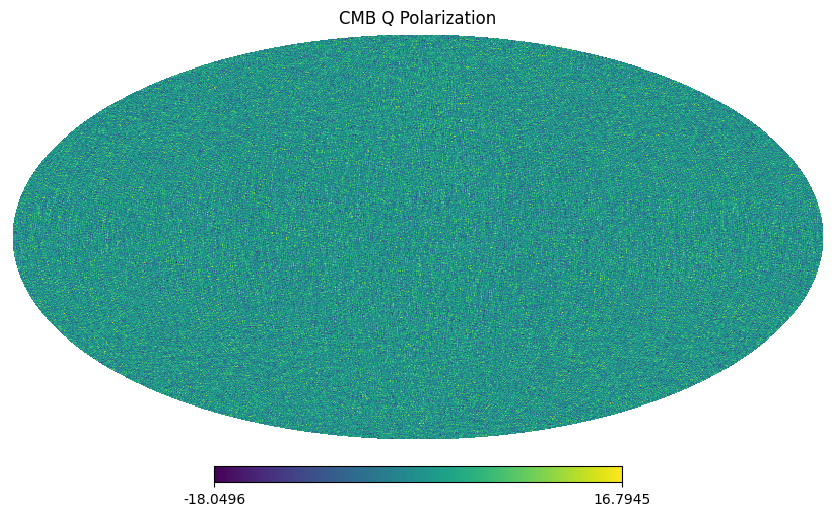

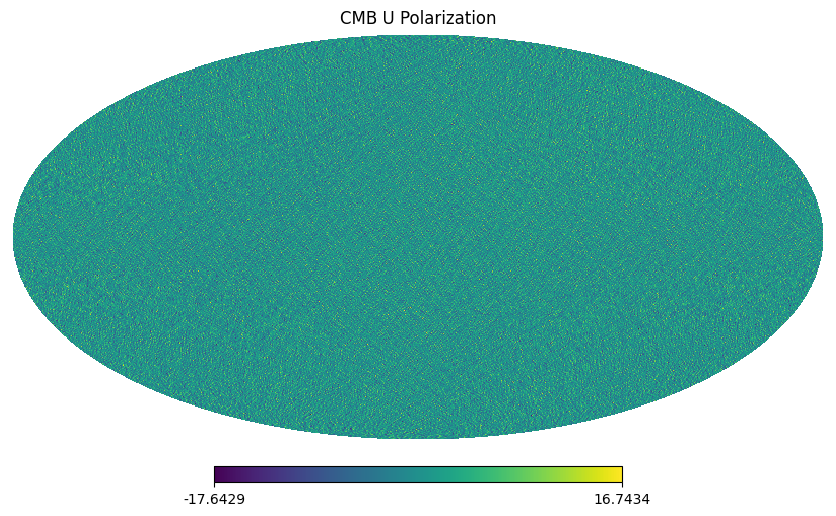

In [4]:
# Generate T, Q, U maps
TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)

# Plotting the maps
hp.mollview(TQU_map[0], title="CMB Temperature (T)")
hp.mollview(TQU_map[1], title="CMB Q Polarization")
hp.mollview(TQU_map[2], title="CMB U Polarization")
plt.show()


In [5]:
# Create containers to store the simulated spectra
cls_TT, cls_EE, cls_BB = [], [], []
cls_TE, cls_TB, cls_EB = [], [], []

# Simulate the maps and computing the spectra
num_sims = 100
for i in range(num_sims):
    TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)
    cl = hp.anafast(TQU_map, lmax=lmax, pol=True)
    cls_TT.append(cl[0])
    cls_EE.append(cl[1])
    cls_BB.append(cl[2])
    cls_TE.append(cl[3])
    cls_EB.append(cl[4])
    cls_TB.append(cl[5])


In [6]:
cls_TT = np.array(cls_TT); cls_EE = np.array(cls_EE); cls_BB = np.array(cls_BB)
cls_TE = np.array(cls_TE); cls_EB = np.array(cls_EB); cls_TB = np.array(cls_TB)

In [7]:
# Let us now compute the mean & std of the simulated spectra:
def mean_and_err(arr):
    arr = np.array(arr)
    return np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1) / np.sqrt(num_sims)

mean_TT, err_TT = mean_and_err(cls_TT)
mean_EE, err_EE = mean_and_err(cls_EE)
mean_BB, err_BB = mean_and_err(cls_BB)
mean_TE, err_TE = mean_and_err(cls_TE)
mean_EB, err_EB = mean_and_err(cls_EB)
mean_TB, err_TB = mean_and_err(cls_TB)

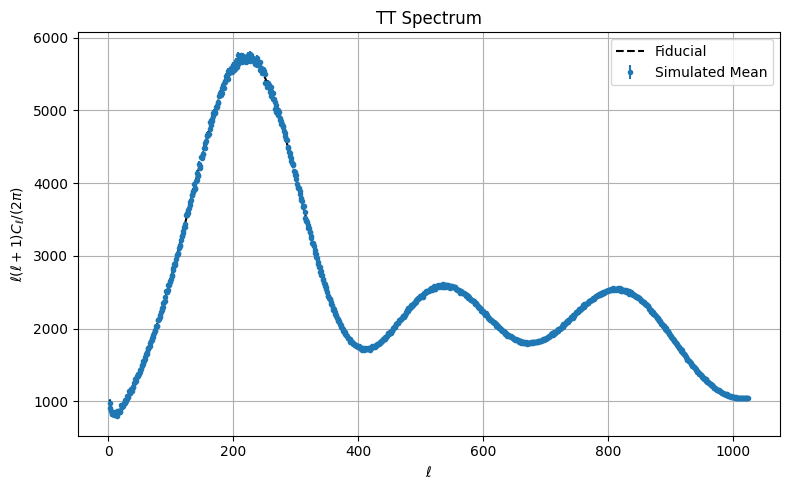

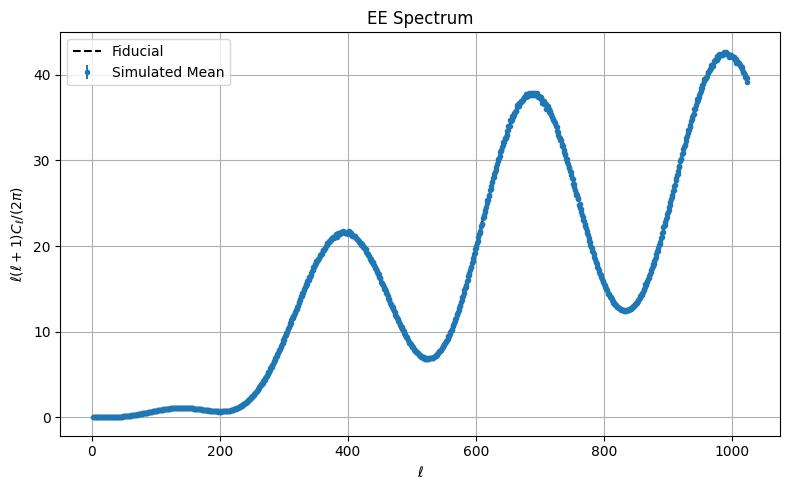

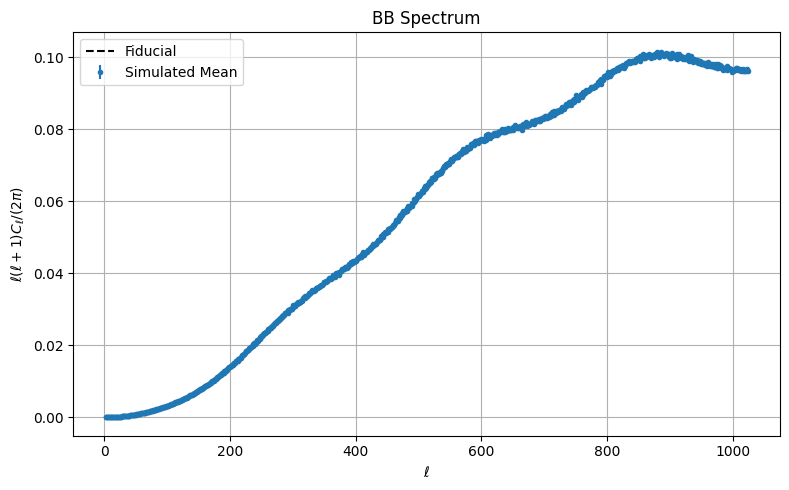

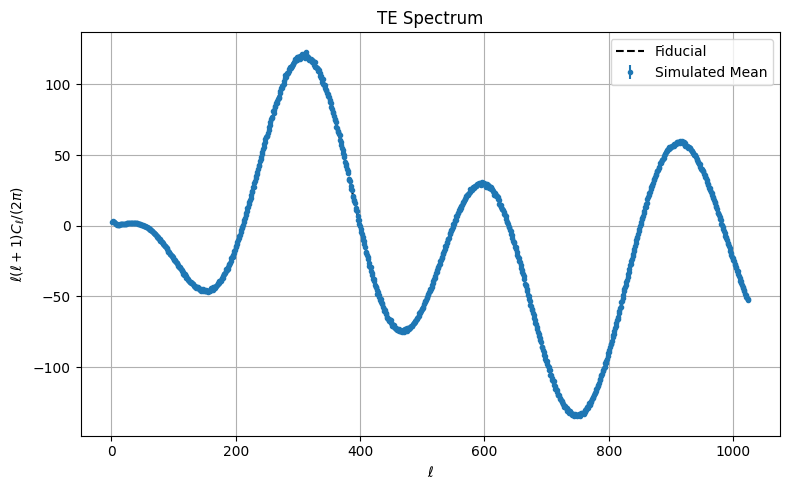

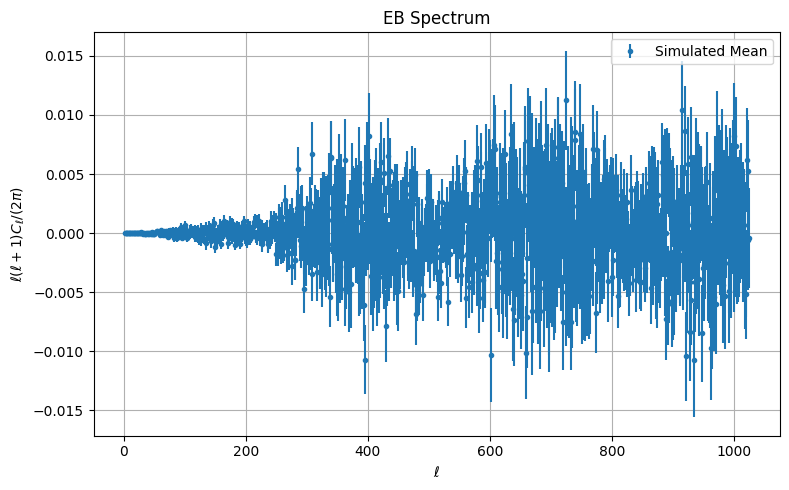

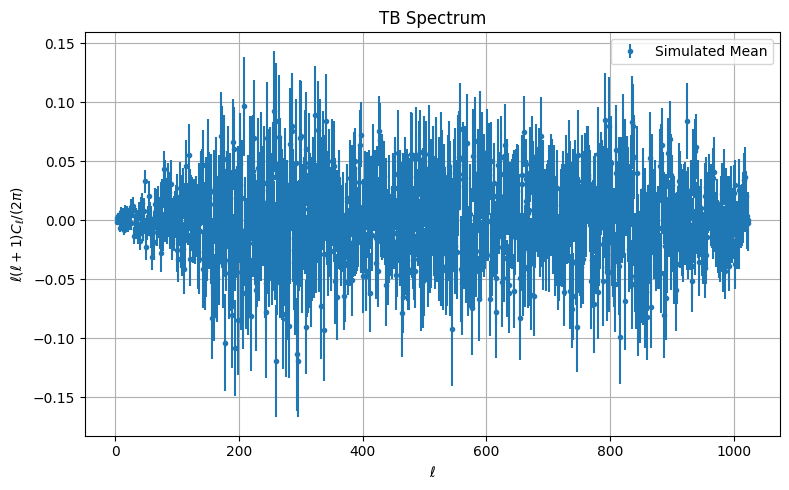

In [8]:
# Plotting the comparison between the fiducial spectra and the simulations:
ell = np.arange(lmax + 1)

def plot_spectrum(ell, mean, err, fid, label):
    plt.figure(figsize=(8,5))
    factor = ell * (ell + 1) / (2 * np.pi)
    plt.errorbar(ell[2:], factor[2:] * mean[2:], factor[2:] * err[2:], fmt='.', label='Simulated Mean')
    if fid is not None:
        plt.plot(ell[2:], factor[2:] * fid[2:], 'k--', label='Fiducial')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
    plt.title(f'{label} Spectrum')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


plot_spectrum(ell, mean_TT, err_TT, Cl_tt, 'TT')
plot_spectrum(ell, mean_EE, err_EE, Cl_ee, 'EE')
plot_spectrum(ell, mean_BB, err_BB, Cl_bb, 'BB')
plot_spectrum(ell, mean_TE, err_TE, Cl_te, 'TE')
plot_spectrum(ell, mean_EB, err_EB, None, 'EB')
plot_spectrum(ell, mean_TB, err_TB, None, 'TB')


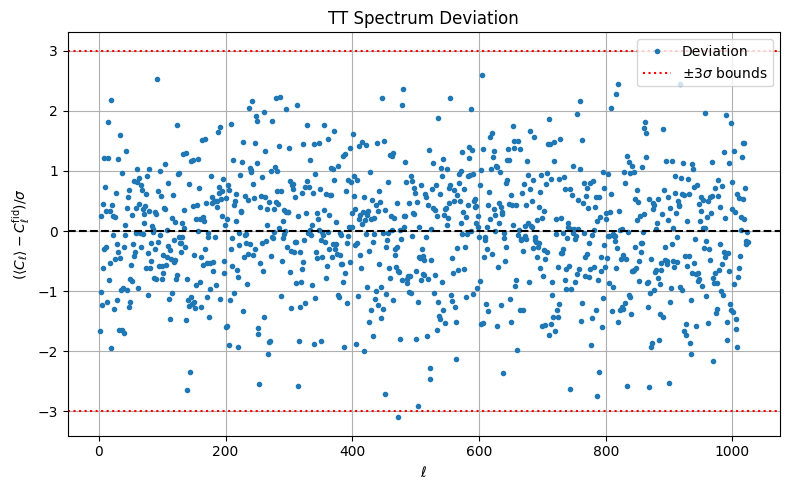

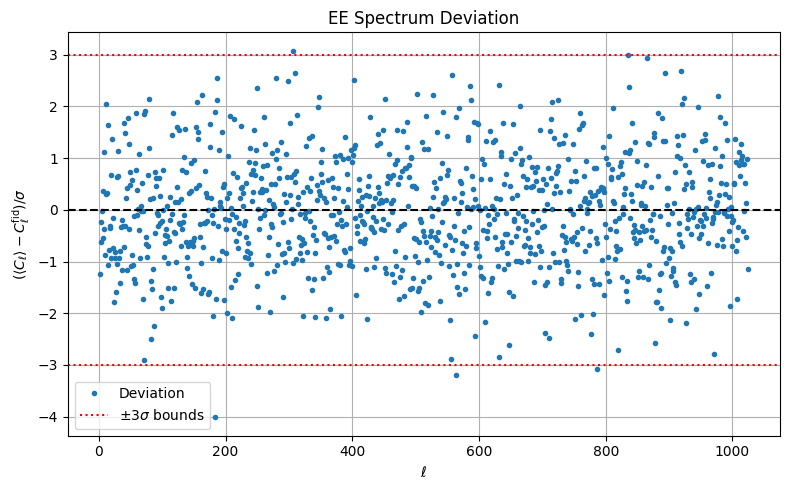

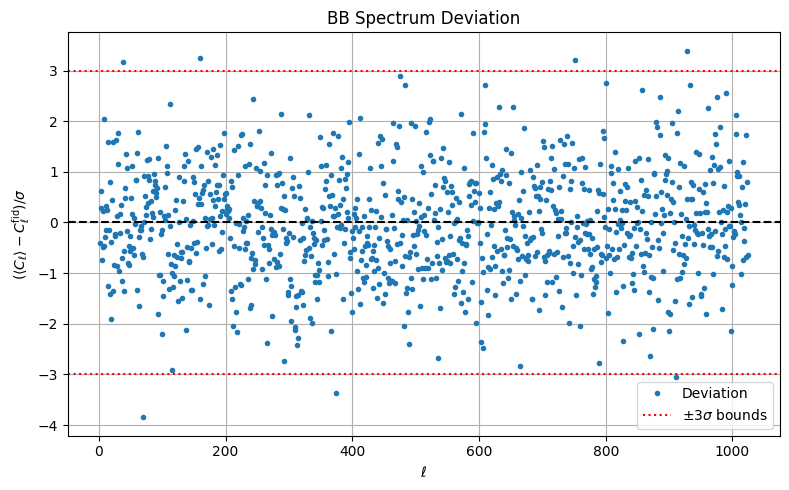

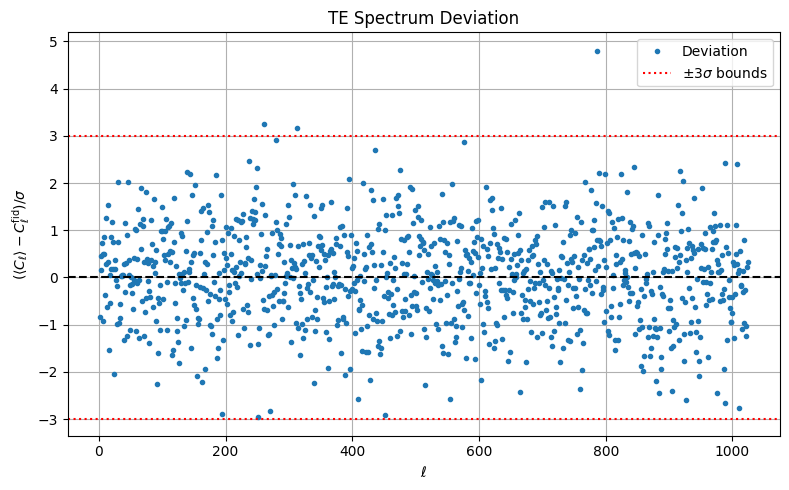

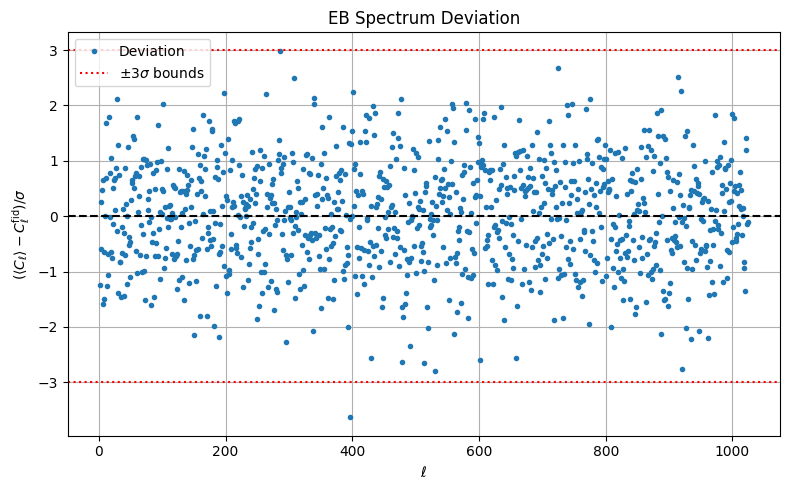

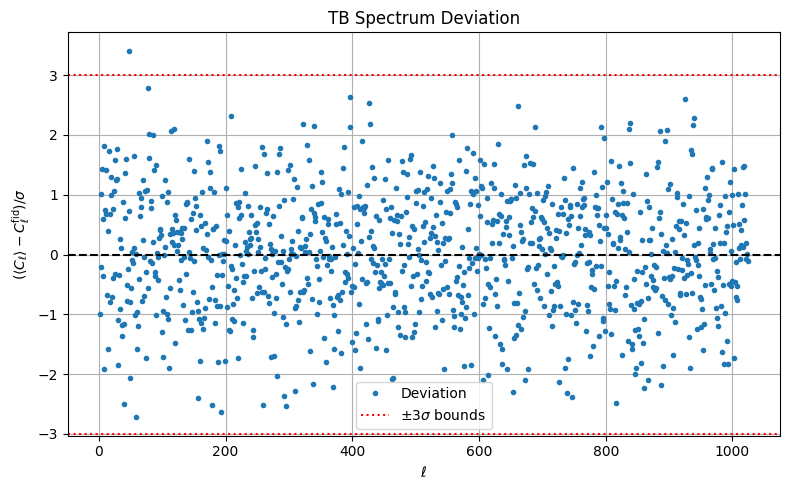

In [9]:
# Compute deviations in units of sigma
def compute_deviation(mean, err, fid, label):
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (mean - fid) / err
        deviation[err == 0] = 0  # Avoid NaNs/Infs where err = 0
    return deviation

dev_TT = compute_deviation(mean_TT, err_TT, Cl_tt, 'TT')
dev_EE = compute_deviation(mean_EE, err_EE, Cl_ee, 'EE')
dev_BB = compute_deviation(mean_BB, err_BB, Cl_bb, 'BB')
dev_TE = compute_deviation(mean_TE, err_TE, Cl_te, 'TE')
dev_EB = compute_deviation(mean_EB, err_EB, np.zeros_like(mean_EB), 'EB')
dev_TB = compute_deviation(mean_TB, err_TB, np.zeros_like(mean_TB), 'TB')


# Plot the Deviations
def plot_deviation(ell, deviation, label):
    plt.figure(figsize=(8, 5))
    plt.plot(ell[2:], deviation[2:], '.', label='Deviation')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(3, color='red', linestyle=':', label=r'$\pm3\sigma$ bounds')
    plt.axhline(-3, color='red', linestyle=':')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$(\langle C_\ell \rangle - C_\ell^\mathrm{fid})/\sigma$')
    plt.title(f'{label} Spectrum Deviation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_deviation(ell, dev_TT, 'TT')
plot_deviation(ell, dev_EE, 'EE')
plot_deviation(ell, dev_BB, 'BB')
plot_deviation(ell, dev_TE, 'TE')
plot_deviation(ell, dev_EB, 'EB')
plot_deviation(ell, dev_TB, 'TB')



### D-Estimators

In [10]:
def D_EB_from_cls(cls_EE, cls_BB, cls_EB, beta):
    """
    D_l^{EB,o}(beta) = C_l^{EB,o} * cos(4 beta) - 0.5 * (C_l^{EE,o} - C_l^{BB,o}) * sin(4 beta)
    """
    return cls_EB * np.cos(4.0 * beta) - 0.5 * (cls_EE - cls_BB) * np.sin(4.0 * beta)

def D_TB_from_cls(cls_TE, cls_TB, beta):
    """
    D_l^{TB,o}(beta) = C_l^{TB,o} * cos(2 beta) - C_l^{TE,o} * sin(2 beta)
    """
    return cls_TB * np.cos(2.0 * beta) - cls_TE * np.sin(2.0 * beta)


In [11]:
def D_estimators_for_sim(sim_index, beta_rad):
    D_EB = D_EB_from_cls(cls_EE[sim_index], cls_BB[sim_index], cls_EB[sim_index], beta_rad)
    D_TB = D_TB_from_cls(cls_TE[sim_index], cls_TB[sim_index], beta_rad)
    return D_EB, D_TB


### χ² for EB only

In [12]:
ell = np.arange(lmax + 1)
# Let us build the inverse covariance weights for EB: C^{-1}_{ll} = (2l+1) / (C_ell^EE C_ell^BB)
# and create a mask that selects multipoles l which are valid for the computation:
valid_EB = (ell >= lmin) & np.isfinite(Cl_ee) & np.isfinite(Cl_bb) & (Cl_ee > 0) & (Cl_bb > 0) 
invCov_EB = np.zeros(lmax + 1)
invCov_EB[valid_EB] = (2.0 * ell[valid_EB] + 1.0) / (Cl_ee[valid_EB] * Cl_bb[valid_EB])

def chi2_EB_for_sim(sim_index, beta_rad):
    """
    χ²_EB(β) = D^T(β) C^{-1} D(β)
    - D from the simulated spectra for this realization
    - C^{-1} from fiducial spectra (Eq. 3.11)
    """
    D_EB, _ = D_estimators_for_sim(sim_index, beta_rad)
    d = D_EB[valid_EB]
    w = invCov_EB[valid_EB]  # diagonal inverse covariance
    return np.dot(d * w, d)

def chi2_EB_for_all_sims(beta_rad):
    return np.array([chi2_EB_for_sim(i, beta_rad) for i in range(num_sims)])

---

### Comparison of the Theoretical Chi-Square to the Chi_Squared from the Simulations

In [13]:
from scipy.stats import chi2

beta_deg = np.linspace(-1, 1, 1000)   
beta_rad = np.deg2rad(beta_deg)

min_chi2_EB = np.zeros(num_sims)
for i in range(num_sims):
    chi2_vals = np.array([chi2_EB_for_sim(i, b) for b in beta_rad])
    min_chi2_EB[i] = chi2_vals.min()


In [14]:
# df = (l_max − l_min + 1) − 1
dof_eff = int(np.sum(valid_EB)) - 1  

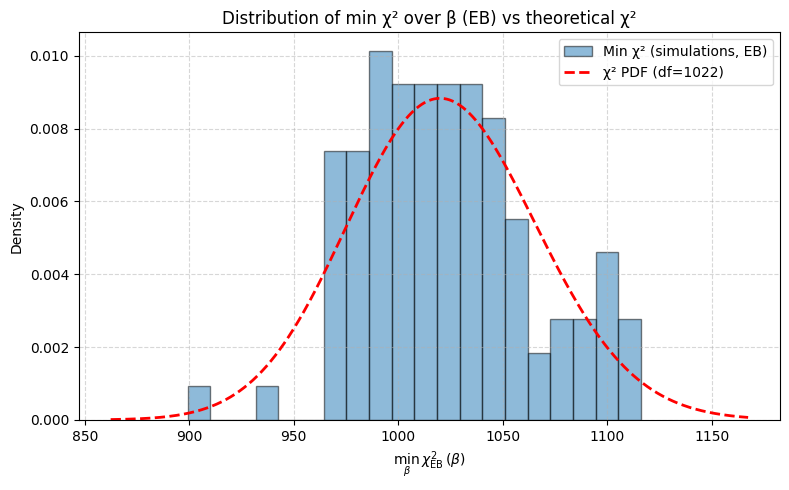

Simulated min χ²: mean=1023.30, std=41.56
Theory χ² mean(df=1022) = 1022.00, std = 45.21


In [15]:
# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(min_chi2_EB, bins=20, density=True,
                           alpha=0.5, color='tab:blue', edgecolor='k',
                           label='Min χ² (simulations, EB)')


x_min = max(0.0, min(min_chi2_EB.min(), chi2.ppf(1e-4, df=dof_eff)))
x_max = max(min_chi2_EB.max(), chi2.ppf(0.999, df=dof_eff))
x = np.linspace(x_min, x_max, 1000)

# Overlay theoretical Chi-Square PDFs with effective dof
plt.plot(x, chi2.pdf(x, df=dof_eff), 'r--', lw=2, label=f'χ² PDF (df={dof_eff})')

plt.xlabel(r'$\min_\beta\,\chi^2_{\rm EB}(\beta)$')
plt.ylabel('Density')
plt.title('Distribution of min χ² over β (EB) vs theoretical χ²')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Simulated min χ²: mean={min_chi2_EB.mean():.2f}, std={min_chi2_EB.std(ddof=1):.2f}")
print(f"Theory χ² mean(df={dof_eff}) = {dof_eff:.2f}, std = {np.sqrt(2*dof_eff):.2f}")

---

In [16]:
# Scan β from -1 to 1 degrees, converted to radians
#beta_deg = np.linspace(-1, 1, 1000)  # 1000 points -> 0.002 deg step
#beta_rad = np.deg2rad(beta_deg)


In [17]:
beta_min_all_EB = np.zeros(num_sims)

for i in range(num_sims):
    # Compute chi^2(β) for this simulation across all β values
    chi2_vals_EB = np.array([chi2_EB_for_sim(i, b) for b in beta_rad])
    
    # Find the index of the minimum chi^2
    min_index = np.argmin(chi2_vals_EB)
    
    # Store the corresponding β
    beta_min_all_EB[i] = beta_rad[min_index]


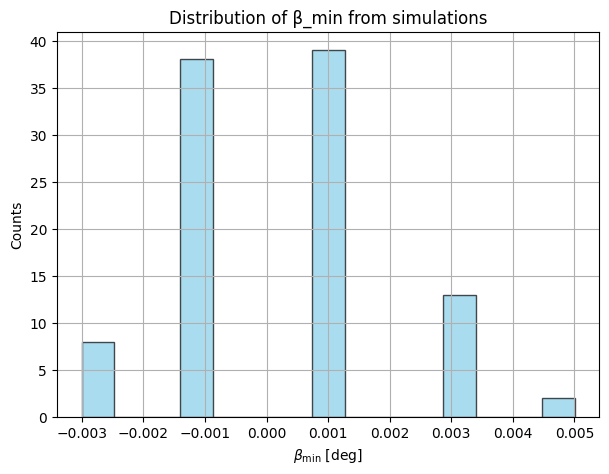

Mean β_min: 0.0003 deg
Std(β_min): 0.0018 deg
SEM(β_min): 0.0002 deg


In [18]:
# Convert to degrees for visualization
beta_min_deg_EB = np.rad2deg(beta_min_all_EB)

# Histogram
plt.figure(figsize=(7,5))
plt.hist(beta_min_deg_EB, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel(r'$\beta_\mathrm{min}$ [deg]')
plt.ylabel('Counts')
plt.title('Distribution of β_min from simulations')
plt.grid(True)
plt.show()

# Mean and standard deviation
mean_beta_EB = np.mean(beta_min_deg_EB)
std_beta_EB = np.std(beta_min_deg_EB, ddof=1)  # standard deviation
sem_beta_EB = std_beta_EB / np.sqrt(num_sims)  # the standard error of the mean of β_min


print(f"Mean β_min: {mean_beta_EB:.4f} deg")
print(f"Std(β_min): {std_beta_EB:.4f} deg")
print(f"SEM(β_min): {sem_beta_EB:.4f} deg")

/tmp/ipykernel_3809/3651903822.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


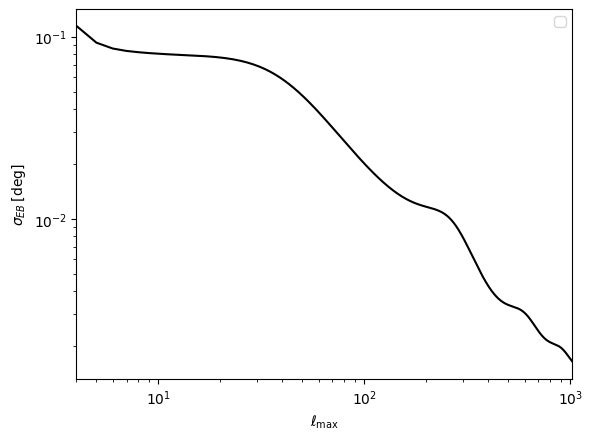

Analytical σ_β (up to lmax=1024): 0.0016 deg


In [19]:
# Analytical Results from the MSc Thesis:

l, TT, TE, EE, BB, PP = np.loadtxt('COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt',unpack=True)
l = l.astype(int)

nside = 512
lmin = 2
lmax = 2 * nside
ell = np.arange(lmax + 1)
clsumEB = np.zeros(lmax + 1)

# Calculate clsumEB for each multipole moment l
for i in range(2, lmax + 1):
    # Calculate the term based on the given formula
    clsumEB[i] = np.sum(4 * (EE[2:i+1] - BB[2:i+1])**2 / (EE[2:i+1] * BB[2:i+1]) * ((2 * l[2:i+1] + 1) + 2))

# Calculate sigmaEB from clsumEB and convert to degrees
sigmaEB = np.degrees(np.sqrt(1. / clsumEB[2:]))

# Plotting sigmaEB
#plt.figure(figsize=(10, 6))
plt.loglog(l[2:lmax + 1], sigmaEB, color='black')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'$\sigma_{EB}\:[\rm deg]$')
plt.xlim(l[2], lmax)
plt.legend()
plt.savefig('sigma_expected_EB.pdf')
plt.show()
plt.close()


sigma_analytical_EB = sigmaEB[-1]  # last element corresponds to lmax
print(f"Analytical σ_β (up to lmax={lmax}): {sigma_analytical_EB:.4f} deg")

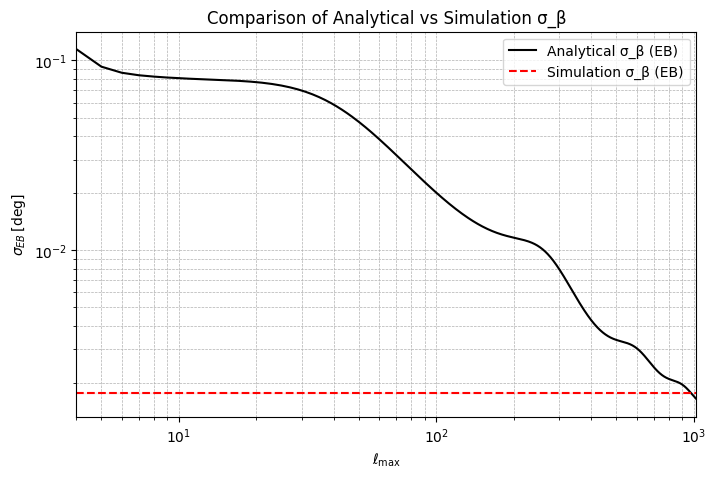

Simulation σ_β (EB) = 0.0018 deg
Analytical σ_β (EB, up to lmax=1024) = 0.0016 deg


In [20]:
# Comparison between the analytical sigma and the simulations:

plt.figure(figsize=(8,5))
plt.loglog(l[2:lmax+1], sigmaEB, color='black', label='Analytical σ_β (EB)')

# Simulation σ_β overlay
plt.axhline(std_beta_EB, color='red', linestyle='--', label='Simulation σ_β (EB)')

# Mark ±1σ around simulation mean
plt.fill_between(l[2:lmax+1], std_beta_EB, std_beta_EB, color='red', alpha=0.1)

plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'$\sigma_{EB} \:[\rm deg]$')
plt.title('Comparison of Analytical vs Simulation σ_β')
plt.xlim(l[2], lmax+1)
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

print(f"Simulation σ_β (EB) = {std_beta_EB:.4f} deg")
print(f"Analytical σ_β (EB, up to lmax={lmax}) = {sigmaEB[-1]:.4f} deg")


### χ² for TB only

In [21]:
def D_estimators_for_sim(sim_index, beta_rad_):
    D_EB = D_EB_from_cls(cls_EE[sim_index], cls_BB[sim_index], cls_EB[sim_index], beta_rad_)
    D_TB = D_TB_from_cls(cls_TE[sim_index], cls_TB[sim_index], beta_rad_)
    return D_EB, D_TB

In [22]:
nside = 512
lmin = 2
lmax = 2 * nside
ell = np.arange(lmax + 1)

# Masking valid multipoles for TB
valid_TB = (ell >= lmin) & np.isfinite(Cl_tt) & np.isfinite(Cl_bb) & (Cl_tt > 0) & (Cl_bb > 0)

# Building inverse covariance for TB
invCov_TB = np.zeros(lmax + 1)
invCov_TB[valid_TB] = (2.0 * ell[valid_TB] + 1.0) / (Cl_tt[valid_TB] * Cl_bb[valid_TB])


In [23]:
def chi2_TB_for_sim(sim_index, beta_rad_):
    _, D_TB = D_estimators_for_sim(sim_index, beta_rad_) 
    d = D_TB[valid_TB]
    w = invCov_TB[valid_TB]
    return np.dot(d * w, d)


In [24]:
def chi2_TB_for_all_sims(beta_rad_):
    return np.array([chi2_TB_for_sim(i, beta_rad_) for i in range(num_sims)])


---

### Comparison of the Theoretical Chi-Square to the Chi_Squared from the Simulations

In [25]:
beta_deg = np.linspace(-1, 1, 1000)   
beta_rad = np.deg2rad(beta_deg)

min_chi2_TB = np.zeros(num_sims)
for i in range(num_sims):
    chi2_vals_TB = np.array([chi2_TB_for_sim(i, b) for b in beta_rad])
    min_chi2_TB[i] = chi2_vals_TB.min()

In [26]:
dof_eff = int(np.sum(valid_TB)) - 1  # N_valid - 1

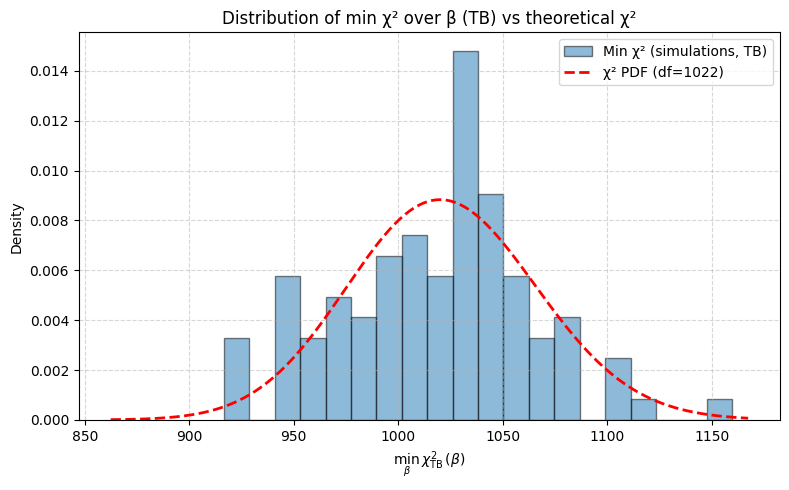

Simulated min χ²: mean=1018.21, std=46.32
Theory χ² mean(df=1022) = 1022.00, std = 45.21


In [27]:
# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(min_chi2_TB, bins=20, density=True,
                           alpha=0.5, color='tab:blue', edgecolor='k',
                           label='Min χ² (simulations, TB)')


x_min = max(0.0, min(min_chi2_TB.min(), chi2.ppf(1e-4, df=dof_eff)))
x_max = max(min_chi2_TB.max(), chi2.ppf(0.999, df=dof_eff))
x = np.linspace(x_min, x_max, 1000)

# Overlay theoretical Chi-Square PDFs with effective dof
plt.plot(x, chi2.pdf(x, df=dof_eff), 'r--', lw=2, label=f'χ² PDF (df={dof_eff})')

plt.xlabel(r'$\min_\beta\,\chi^2_{\rm TB}(\beta)$')
plt.ylabel('Density')
plt.title('Distribution of min χ² over β (TB) vs theoretical χ²')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Simulated min χ²: mean={min_chi2_TB.mean():.2f}, std={min_chi2_TB.std(ddof=1):.2f}")
print(f"Theory χ² mean(df={dof_eff}) = {dof_eff:.2f}, std = {np.sqrt(2*dof_eff):.2f}")

---

In [28]:
# Scan β from -1 to 1 degrees, converted to radians
#beta_deg = np.linspace(-1, 1, 1000)  # 1000 points -> 0.002 deg step
#beta_rad = np.deg2rad(beta_deg)

In [29]:
beta_min_all_TB = np.zeros(num_sims)

for i in range(num_sims):
    # chi^2(β) for this simulation
    chi2_vals_TB = np.array([chi2_TB_for_sim(i, b) for b in beta_rad])
    
    # Find β corresponding to minimum chi^2
    min_index = np.argmin(chi2_vals_TB)
    beta_min_all_TB[i] = beta_rad[min_index]

# Convert to degrees
beta_min_deg_TB = np.rad2deg(beta_min_all_TB)


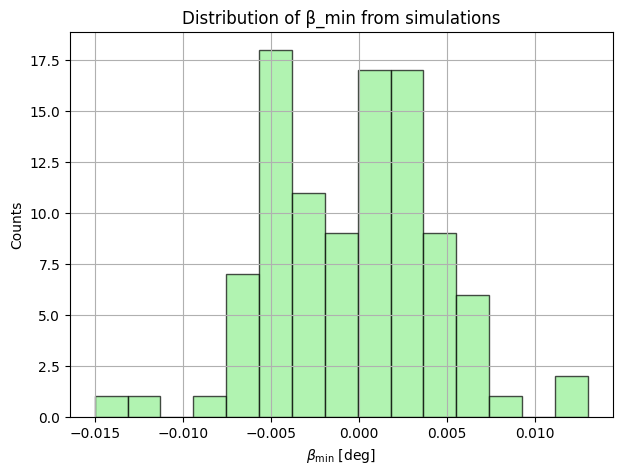

Mean β_min: -0.0003 deg
Std(β_min): 0.0050 deg
SEM(β_min): 0.0005 deg


In [30]:
# Histogram
plt.figure(figsize=(7,5))
plt.hist(beta_min_deg_TB, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel(r'$\beta_\mathrm{min}$ [deg]')
plt.ylabel('Counts')
plt.title('Distribution of β_min from simulations')
plt.grid(True)
plt.show()

# Mean and standard deviation
mean_beta_TB = np.mean(beta_min_deg_TB)
std_beta_TB = np.std(beta_min_deg_TB, ddof=1) #standard deviation
sem_beta_TB = std_beta_TB / np.sqrt(num_sims)  # the standard error of the mean of β_min

print(f"Mean β_min: {mean_beta_TB:.4f} deg")
print(f"Std(β_min): {std_beta_TB:.4f} deg")
print(f"SEM(β_min): {sem_beta_TB:.4f} deg")

/tmp/ipykernel_3809/1219953987.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


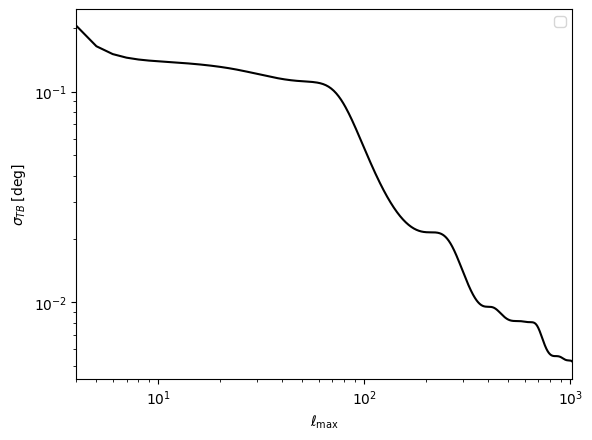

Analytical σ_β (up to lmax=1024): 0.0052 deg


In [31]:
# Analytical Results from the MSc Thesis:

l, TT, TE, EE, BB, PP = np.loadtxt('COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt',unpack=True)
l = l.astype(int)

nside = 512
lmin = 2
lmax = 2 * nside
ell = np.arange(lmax + 1)


clsumTB = np.zeros(lmax + 1)

# Calculate chi_squared for each multipole moment l
for i in range(2, lmax + 1):
    clsumTB[i] = np.sum(4 * ((EE[2:i+1] - BB[2:i+1]) / BB[2:i+1] + (2 * l[2:i+1] + 1) * (TE[2:i+1]**2) / (TT[2:i+1] * BB[2:i+1]) + (TE[2:i+1]**2) / (TT[2:i+1] * BB[2:i+1])))

# Calculating sigmaTB from clsumTB, converting to degrees
sigmaTB = np.degrees(np.sqrt(1. / clsumTB[2:]))

# Plotting sigmaTB
#plt.figure(figsize=(10, 6))
plt.loglog(l[2:lmax + 1], sigmaTB, color='black')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'$\sigma_{TB}\:[\rm deg]$')
plt.xlim(l[2], lmax)
plt.legend()
plt.show()
plt.close()


sigma_analytical = sigmaTB[-1]  # last element corresponds to lmax
print(f"Analytical σ_β (up to lmax={lmax}): {sigma_analytical:.4f} deg")

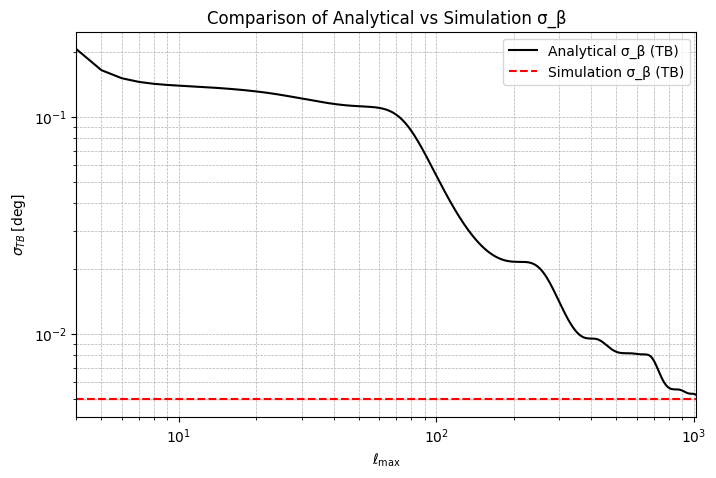

Simulation σ_β (TB) = 0.0050 deg
Analytical σ_β (TB, up to lmax=1024) = 0.0052 deg


In [32]:
# Comparison between the analytical sigma and the simulations:

plt.figure(figsize=(8,5))
plt.loglog(l[2:lmax+1], sigmaTB, color='black', label='Analytical σ_β (TB)')

# Simulation σ_β overlay
plt.axhline(std_beta_TB, color='red', linestyle='--', label='Simulation σ_β (TB)')

# Mark ±1σ around simulation mean
plt.fill_between(l[2:lmax+1], std_beta_TB, std_beta_TB, color='red', alpha=0.1)

plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'$\sigma_{TB} \:[\rm deg]$')
plt.title('Comparison of Analytical vs Simulation σ_β')
plt.xlim(l[2], lmax+1)
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

print(f"Simulation σ_β (TB) = {std_beta_TB:.4f} deg")
print(f"Analytical σ_β (TB, up to lmax={lmax}) = {sigmaTB[-1]:.4f} deg")


### χ² for the joint estimator: EB + TB (based on their auto- and cross-covariance matrices)

In [33]:
# Definitions of the covariance matrices:
# X_ll' = δ_ll' (2l+1) * [ C_ee / (C_tt C_bb) ] * [ C_ee - (C_te)^2 / C_tt ]^{-1}
# Y_ll' = Z_ll' = - δ_ll' (2l+1) * [ C_te / (C_tt C_bb) ] * [ C_ee - (C_te)^2 / C_tt ]^{-1}
# W_ll' = δ_ll' (2l+1) * [ 1 / C_bb ] * [ C_ee - (C_te)^2 / C_tt ]^{-1}

eps = 1e-30 
ell = np.arange(lmax + 1)
# Build a validity mask for diagonal blocks 
valid_joint = ( (ell >= lmin) & np.isfinite(Cl_tt) & np.isfinite(Cl_ee) & np.isfinite(Cl_bb) & np.isfinite(Cl_te) & (Cl_tt > 0) & (Cl_bb > 0))

# Compute the inverse of the bracket safely:
# inv_bracket_l = [ C_ee - (C_te)^2 / C_tt ]^{-1}
with np.errstate(divide='ignore', invalid='ignore'):
    inv_bracket = 1.0 / np.clip(Cl_ee - (Cl_te**2) / Cl_tt, eps, np.inf)

X = np.zeros(lmax + 1)
Y = np.zeros(lmax + 1)
W = np.zeros(lmax + 1)

X[valid_joint] = (2.0 * ell[valid_joint] + 1.0) * \
                 (Cl_ee[valid_joint] / (Cl_tt[valid_joint] * Cl_bb[valid_joint])) * \
                 inv_bracket[valid_joint]

Y[valid_joint] = -(2.0 * ell[valid_joint] + 1.0) * \
                 (Cl_te[valid_joint] / (Cl_tt[valid_joint] * Cl_bb[valid_joint])) * \
                 inv_bracket[valid_joint]

W[valid_joint] = (2.0 * ell[valid_joint] + 1.0) * \
                 (1.0 / Cl_bb[valid_joint]) * \
                 inv_bracket[valid_joint]



In [34]:
def chi2_joint_for_sim(sim_index, beta_rad_):
    '''
    χ²_joint(β)=  D_l^{TB,o} X_{ll'} D_{l'}^{TB,o} 
                 + D_l^{TB,o} Y_{ll'} D_{l'}^{EB,o} + D_l^{EB,o} Z_{ll'} D_{l'}^{TB,o}
                 + D_l^{EB,o} W_{ll'} D_{l'}^{EB,o}
    '''
    D_EB, D_TB = D_estimators_for_sim(sim_index, beta_rad_)
    dTB = D_TB[valid_joint]
    dEB = D_EB[valid_joint]
    # δ_ll' => only diagonal l contribute: sum per-l quadratic form
    return np.sum(X[valid_joint] * dTB**2 + 2.0 * Y[valid_joint] * dTB * dEB + W[valid_joint] * dEB**2)
    
def chi2_joint_for_all_sims(beta_rad_):
    return np.array([chi2_joint_for_sim(i, beta_rad_) for i in range(num_sims)])

---

### Comparison of the Theoretical Chi-Square to the Chi_Squared from the Simulations

In [35]:
beta_deg = np.linspace(-1, 1, 1000)   
beta_rad = np.deg2rad(beta_deg)

min_chi2_joint = np.zeros(num_sims)
for i in range(num_sims):
    chi2_vals_joint = np.array([chi2_joint_for_sim(i, b) for b in beta_rad])
    min_chi2_joint[i] = chi2_vals_joint.min()

In [36]:
dof_eff = 2 * int(np.sum(valid_joint)) - 1  # 2*N_valid - 1

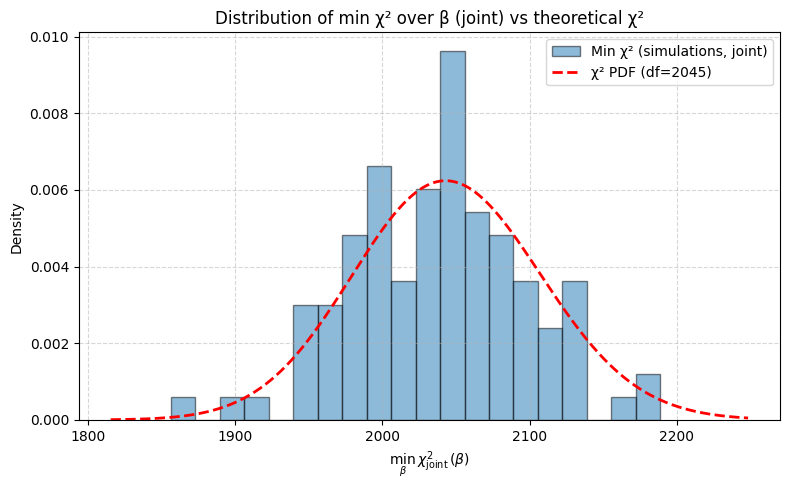

Simulated min χ²: mean=2037.88, std=60.51
Theory χ² mean(df=2045) = 2045.00, std = 63.95


In [37]:
# Histogram

plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(min_chi2_joint, bins=20, density=True,
                           alpha=0.5, color='tab:blue', edgecolor='k',
                           label='Min χ² (simulations, joint)')

x_min = max(0.0, min(min_chi2_joint.min(), chi2.ppf(1e-4, df=dof_eff)))
x_max = max(min_chi2_joint.max(), chi2.ppf(0.999, df=dof_eff))
x = np.linspace(x_min, x_max, 1000)

plt.plot(x, chi2.pdf(x, df=dof_eff), 'r--', lw=2, label=f'χ² PDF (df={dof_eff})')

plt.xlabel(r'$\min_{\beta}\,\chi^2_{\text{joint}}(\beta)$')
plt.ylabel('Density')
plt.title('Distribution of min χ² over β (joint) vs theoretical χ²')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Simulated min χ²: mean={min_chi2_joint.mean():.2f}, std={min_chi2_joint.std(ddof=1):.2f}")
print(f"Theory χ² mean(df={dof_eff}) = {dof_eff:.2f}, std = {np.sqrt(2*dof_eff):.2f}")

---

In [38]:
#beta_deg = np.linspace(-1, 1, 1000)  # ~0.002° steps
#beta_rad = np.deg2rad(beta_deg)

In [39]:
# Find β (argmin χ²_joint) per simulation
beta_min_all_joint = np.zeros(num_sims)
for i in range(num_sims):
    chi2_vals_joint = np.array([chi2_joint_for_sim(i, b) for b in beta_rad])
    min_index = np.argmin(chi2_vals_joint)
    beta_min_all_joint[i] = beta_rad[min_index]

# Convert to degrees
beta_min_deg_joint = np.rad2deg(beta_min_all_joint)

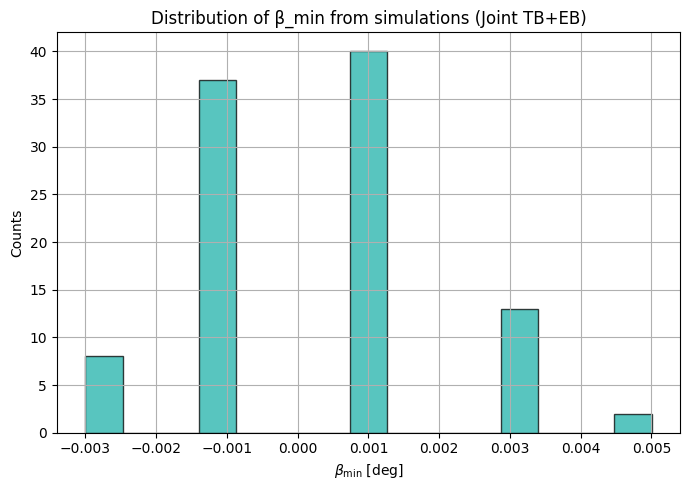

Joint Mean β_min: 0.0003 deg
Joint Std(β_min): 0.0018 deg
Standard Error of the Mean (β_min): 0.0002 deg


In [40]:
plt.figure(figsize=(7,5))
plt.hist(beta_min_deg_joint, bins=15, alpha=0.75, color='lightseagreen', edgecolor='black')
plt.xlabel(r'$\beta_\mathrm{min}$ [deg]')
plt.ylabel('Counts')
plt.title('Distribution of β_min from simulations (Joint TB+EB)')
plt.grid(True)
plt.tight_layout()
plt.show()

mean_beta_joint = np.mean(beta_min_deg_joint)
std_beta_joint  = np.std(beta_min_deg_joint, ddof=1)
sem_beta_joint = std_beta_joint / np.sqrt(num_sims)  # the standard error of the mean of β_min

print(f"Joint Mean β_min: {mean_beta_joint:.4f} deg")
print(f"Joint Std(β_min): {std_beta_joint:.4f} deg")
print(f"Standard Error of the Mean (β_min): {sem_beta_joint:.4f} deg")


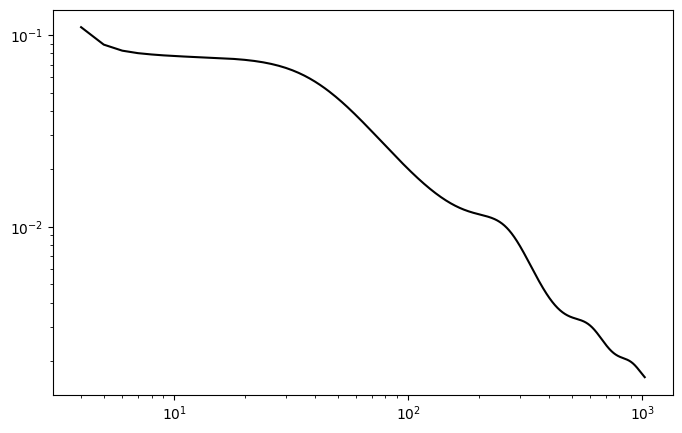

In [41]:
# Analytical Results from the MSc Thesis:

l, TT, TE, EE, BB, PP = np.loadtxt('COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt',unpack=True)
l = l.astype(int)

nside = 512
lmin = 2
lmax = 2 * nside
ell = np.arange(lmax + 1)

clsum_joint = np.zeros(lmax + 1)

# Calculate chi_squared for each multipole moment l

for i in range(2, lmax + 1):
    l_range = l[2:i+1]

    term1 = (EE[2:i+1] - (TE[2:i+1]**2 / TT[2:i+1]))**(-1) * EE[2:i+1]

    inner_bracket_1 = 4 * ((EE[2:i+1] - BB[2:i+1]) / BB[2:i+1]
                           + (TE[2:i+1]**2 / (TT[2:i+1] * BB[2:i+1]))
                           + (2 * l_range + 1) * (TE[2:i+1]**2 / (TT[2:i+1] * BB[2:i+1])))

    inner_bracket_2 = -2 * (TE[2:i+1]**2 / TT[2:i+1]) * (8 / BB[2:i+1]
                           - 10 / EE[2:i+1]
                           + 4 * (2 * l_range + 1) * (EE[2:i+1] - BB[2:i+1]) / (BB[2:i+1] * EE[2:i+1]))

    inner_bracket_3 = ((EE[2:i+1] - BB[2:i+1])**2 / (BB[2:i+1] * EE[2:i+1])) * ((8 + 4 * (2 * l_range + 1)))

    curly_brackets = inner_bracket_1 + inner_bracket_2 + inner_bracket_3

    clsum_joint[i] = np.sum(term1 * curly_brackets)

sigma_joint_analytic= np.degrees(np.sqrt(1.0 / clsum_joint[2:]))


# Plot analytical σ_joint
plt.figure(figsize=(8,5))
plt.loglog(l[2:lmax+1], sigma_joint_analytic, color='black', label='Analytical σ_joint')


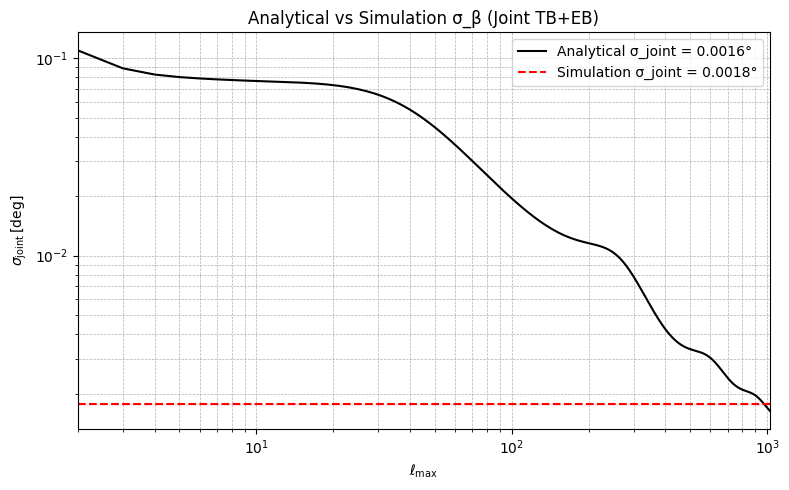

Simulation σ_joint = 0.0018 deg
Analytical σ_joint (up to lmax=1024) = 0.0016 deg


In [42]:
# Combined plot: analytical curve + simulation horizontal line
epsilon = 1e-9  # ensure visibility of horizontal line on log scale
sim_line = max(std_beta_joint, epsilon)

plt.figure(figsize=(8,5))
plt.loglog(ell[2:lmax+1], sigma_joint_analytic, color='black', label=f'Analytical σ_joint = {sigma_joint_analytic[-1]:.4f}°')
plt.axhline(sim_line, color='red', linestyle='--', label=f'Simulation σ_joint = {std_beta_joint:.4f}°')

plt.fill_between(ell[2:lmax+1], sim_line, sim_line, color='red', alpha=0.1)

plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'$\sigma_{\text{joint}}\:[\rm deg]$')
plt.title('Analytical vs Simulation σ_β (Joint TB+EB)')
plt.xlim(ell[2], lmax+1)
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

print(f"Simulation σ_joint = {std_beta_joint:.4f} deg")
print(f"Analytical σ_joint (up to lmax={lmax}) = {sigma_joint_analytic[-1]:.4f} deg")

---

Simulation σ_β (EB) = 0.0018 deg

Analytical σ_β (EB, up to lmax=1024) = 0.0016 deg

---

Simulation σ_β (TB) = 0.0050 deg

Analytical σ_β (TB, up to lmax=1024) = 0.0052 deg

---

Simulation σ_joint = 0.0018 deg

Analytical σ_joint (up to lmax=1024) = 0.0016 deg


---